In [1]:
# Import Core Packages
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform
import shutil

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/home/kimqi/Documents/Repositories/NeuroPy']) 

In [2]:
# Import NeuroPy Packages
from neuropy import core
from neuropy.core.session import ProcessData

# Packages for Probe Configuration
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

# Ripples
from neuropy.analyses import oscillations

# Neurons
from neuropy.io import PhyIO
from neuropy.core import Neurons
from neuropy.core import BinnedSpiketrain
from neuropy.core.neurons import binned_pe_raster

from neuropy.analyses.spkepochs import detect_pbe_epochs
from neuropy.core import Epoch
from neuropy.io.openephysio import *

# Plotting
from neuropy.plotting import Fig
from neuropy.plotting import spikes
from neuropy.core.neurons import pe_raster

In [3]:
from neuropy.utils.ccg import correlograms
from neuropy.utils.mathutil import contiguous_regions
from neuropy.io.openephysio import get_dat_timestamps
from neuropy.plotting import Fig
from neuropy.io.binarysignalio import BinarysignalIO
from neuropy.plotting.signals import plot_signal_traces
from neuropy.utils.signal_process import filter_sig

In [4]:
# Import Data Directory
basepath = Path('/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1')
save_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Preliminary')
plot_dir = Path('/home/kimqi/Documents/Code/PlaceCellDisruption/Analyses/Plots')
sess = ProcessData(basepath)
print(sess.recinfo)
print(sess.eegfile)

signal = sess.eegfile.get_signal()
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')

filename: /media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1/Creampuff_Homecage1.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250

duration: 3851.64 seconds 
duration: 1.07 hours 

Existing artifact epochs file loaded


/media/kimqi/BK/Data/PCDisruption/Recording_Rats/Creampuff/2024_06_22_HomeCage1/Creampuff_Homecage1.probegroup.npy saved


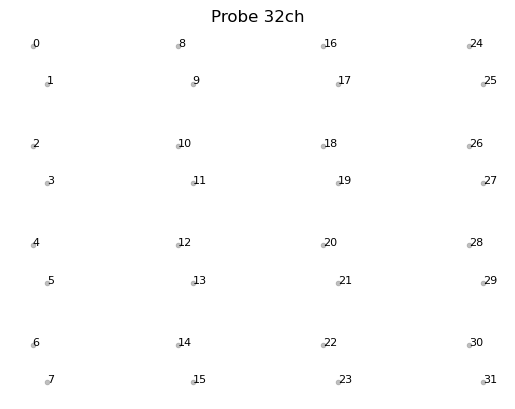

In [5]:
# Set Probe Configuration
shanks = []
channel_groups = sess.recinfo.channel_groups

for i in range(4):
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=4,
        xpitch=15,
        ypitch=20,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]),
    )
    shanks.append(shank)
    #shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe1 = Probe(shanks,shank_pitch=(150,0))

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
plot_probe(prbgrp)
sess.prbgrp = prbgrp


In [6]:
ttl_events = load_all_ttl_events(sess.basepath)
stim_on_events = ttl_events.loc[ttl_events["channel_states"] == 1, "sample_number"]
stim_off_events = ttl_events.loc[ttl_events["channel_states"] == -1, "sample_number"]
stim_on_events / 30000

s_label = []
for i in range(0, len(stim_on_events)):
    if i < 10:
        s_label.append("s1_50uA")
    elif i < 20:
        s_label.append("s1_40uA")
    elif i < 30:
        s_label.append("s1_30uA")
    elif i < 40:
        s_label.append("s2_50uA")
    elif i < 50:
        s_label.append("s2_40uA")
    elif i < 60:
        s_label.append("s2_30uA")
    elif i < 72:
        s_label.append("s3_50uA")
    elif i < 82:
        s_label.append("s3_40uA")
    elif i < 92:
        s_label.append("s3_30uA")
    elif i < 104:
        s_label.append("s4_50uA")
    elif i < 114:
        s_label.append("s4_40uA")
    else:
        s_label.append("s4_30uA")

stim_label = pd.Series(s_label)

In [7]:
stim_epochs_file = sess.filePrefix.with_suffix(".stim_epochs.npy")
stim_epochs = Epoch(pd.DataFrame({
    "start": stim_on_events.reset_index(drop=True) / 30000, 
    "stop": stim_off_events.reset_index(drop=True) / 30000, 
    "label": stim_label
}))
show_epochs = stim_epochs.to_dataframe()
pd.set_option('display.max_rows', None)
#print(show_epochs)

In [8]:
# Split epochs into stim events
s1_stims = show_epochs[show_epochs["label"].str.contains("s1")].reset_index(drop=True)
s2_stims = show_epochs[show_epochs["label"].str.contains("s2")].reset_index(drop=True)
s3_stims = show_epochs[show_epochs["label"].str.contains("s3")].reset_index(drop=True)
s4_stims = show_epochs[show_epochs["label"].str.contains("s4")].reset_index(drop=True)

# Get start times for all trials
s1_start = s1_stims['start'].to_numpy()
s2_start = s2_stims['start'].to_numpy()
s3_start = s3_stims['start'].to_numpy()
s4_start = s4_stims['start'].to_numpy()

In [10]:
# Neurons
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)

sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, shank_ids=sess.phy.shank_ids)

sess.neurons.shank_ids

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


array([1., 4., 4., 1., 2., 4., 2., 4., 1., 4., 4., 3., 4., 4., 3., 4., 4.,
       4., 3., 4., 4., 3., 2., 2., 2., 4., 1., 1., 2., 1., 2., 3., 4., 4.,
       4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [11]:
for sh in np.unique(sess.neurons.shank_ids.astype(int)):
    sess.recinfo.write_neurons(sess.neurons.neuron_slice(np.where(sess.neurons.shank_ids == sh)[0]), suffix_num=sh)

sess.neurons.shank_ids

array([1., 4., 4., 1., 2., 4., 2., 4., 1., 4., 4., 3., 4., 4., 3., 4., 4.,
       4., 3., 4., 4., 3., 2., 2., 2., 4., 1., 1., 2., 1., 2., 3., 4., 4.,
       4., 4., 4., 4., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4.])

In [17]:
# Plot Neuron by Shank Stims
'''
Plot by Shank, then plot average firing rate over trials overlayed onto the plots. Save to a save directory.
'''

b_size = 0.25
for i in range(0, len(sess.neurons)):
    nid = i
    
    cell_fig, ax = plt.subplots(1,4)
    cell_fig.set_size_inches([12,3])
    sid = int(sess.neurons.shank_ids[nid])

    
    s1_cell = pe_raster(neurons=sess.neurons, neuron_id=nid, event_times=s1_start, buffer_sec=(1,2))
    s2_cell = pe_raster(neurons=sess.neurons, neuron_id=nid, event_times=s2_start, buffer_sec=(1,2))
    s3_cell = pe_raster(neurons=sess.neurons, neuron_id=nid, event_times=s3_start, buffer_sec=(1,2))
    s4_cell = pe_raster(neurons=sess.neurons, neuron_id=nid, event_times=s4_start, buffer_sec=(1,2))
    
    spikes.plot_raster(s1_cell, ax=ax[0],markersize=3)
    spikes.plot_raster(s2_cell, ax=ax[1],markersize=3)
    spikes.plot_raster(s3_cell, ax=ax[2],markersize=3)
    spikes.plot_raster(s4_cell, ax=ax[3],markersize=3)
    
    
    for i in range(0,4):
        ax[i].axvspan(0, 1, ymin=0, ymax=1, color='blue', alpha=0.1)
        ax[i].set_ylim(0,32)
        ax[i].set_xlabel('')
        
    for i in range(1,4):
            ax[i].axes.get_yaxis().set_visible(False)
    
    plt.suptitle(f'Cell {nid} (Loc: S{sid}) Stims', fontsize=14, y=1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to fit the title better
    ax[0].set_ylabel("Trials")
    ax[0].set_title("Shank 1")
    ax[1].set_title("Shank 2")
    ax[2].set_title("Shank 3")
    ax[3].set_title("Shank 4")

    s1_fr = s1_cell.get_binned_spiketrains(bin_size=b_size)
    s1_binned_averages = s1_fr.spike_counts.mean(axis=0)
    
    s2_fr = s2_cell.get_binned_spiketrains(bin_size=b_size)
    s2_binned_averages = s2_fr.spike_counts.mean(axis=0)
    
    s3_fr = s3_cell.get_binned_spiketrains(bin_size=b_size)
    s3_binned_averages = s3_fr.spike_counts.mean(axis=0)
    
    s4_fr = s4_cell.get_binned_spiketrains(bin_size=b_size)
    s4_binned_averages = s4_fr.spike_counts.mean(axis=0)
    
    x_values = np.linspace(-1, 2, len(s1_binned_averages))
    # Overlaying the average firing rate onto the first subplot (Shank 1)
    ax[0].plot(x_values, s1_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
    ax[1].plot(x_values, s2_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
    ax[2].plot(x_values, s3_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
    ax[3].plot(x_values, s4_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')

    # Set the firing rate axis with the desired limits
    firing_rate_axis = ax[3].secondary_yaxis('right')
    firing_rate_axis.set_ylabel('Firing Rate (Hz)')
    firing_rate_axis.set_ylim(0, 20)  # Set y-axis limit for firing rate to be at maximum of 20
    
    ax[0].legend()
    ax[0].legend(loc='upper left', bbox_to_anchor=(0,-0.15))

    cell_fig.text(0.5, 0.05, 'Time (s)', ha='center', fontsize=12)

    plot_name = f'Cell_{nid}_S{sid}.png' 
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(plot_dir / plot_name, dpi=300, bbox_inches='tight')  # Save with full path
    plt.close()

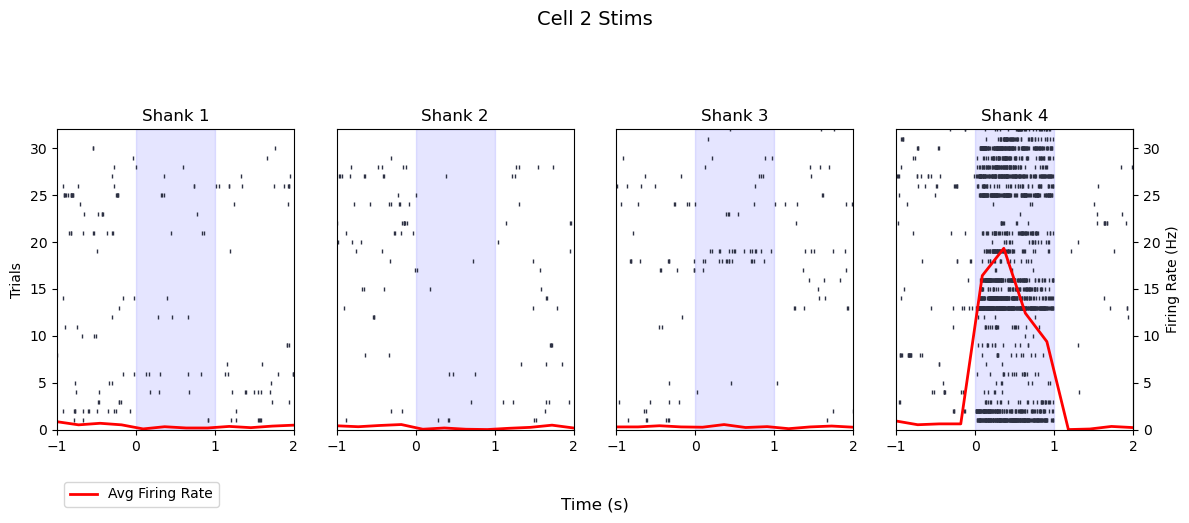

In [16]:
# Test Function for above

nid = 2
b_size = 0.25

cell_fig, ax = plt.subplots(1,4)
cell_fig.set_size_inches([12,5])
s1_cell = pe_raster(neurons=sess.neurons, neuron_id=nid, event_times=s1_start, buffer_sec=(1,2))
s2_cell = pe_raster(neurons=sess.neurons, neuron_id=nid, event_times=s2_start, buffer_sec=(1,2))
s3_cell = pe_raster(neurons=sess.neurons, neuron_id=nid, event_times=s3_start, buffer_sec=(1,2))
s4_cell = pe_raster(neurons=sess.neurons, neuron_id=nid, event_times=s4_start, buffer_sec=(1,2))

spikes.plot_raster(s1_cell, ax=ax[0],markersize=3)
spikes.plot_raster(s2_cell, ax=ax[1],markersize=3)
spikes.plot_raster(s3_cell, ax=ax[2],markersize=3)
spikes.plot_raster(s4_cell, ax=ax[3],markersize=3)

for i in range(0,4):
    ax[i].axvspan(0, 1, ymin=0, ymax=1, color='blue', alpha=0.1)
    ax[i].set_ylim(0,32)
    ax[i].set_xlabel('') 

for i in range(1,4):
    ax[i].axes.get_yaxis().set_visible(False)

plt.suptitle(f'Cell {nid} Stims', fontsize=14, y=1.05)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to fit the title better
ax[0].set_ylabel("Trials")
ax[0].set_title("Shank 1")
ax[1].set_title("Shank 2")
ax[2].set_title("Shank 3")
ax[3].set_title("Shank 4")

s1_fr = s1_cell.get_binned_spiketrains(bin_size=b_size)
s1_binned_averages = s1_fr.spike_counts.mean(axis=0)

s2_fr = s2_cell.get_binned_spiketrains(bin_size=b_size)
s2_binned_averages = s2_fr.spike_counts.mean(axis=0)

s3_fr = s3_cell.get_binned_spiketrains(bin_size=b_size)
s3_binned_averages = s3_fr.spike_counts.mean(axis=0)

s4_fr = s4_cell.get_binned_spiketrains(bin_size=b_size)
s4_binned_averages = s4_fr.spike_counts.mean(axis=0)

x_values = np.linspace(-1, 2, len(s1_binned_averages))
# Overlaying the average firing rate onto the first subplot (Shank 1)
ax[0].plot(x_values, s1_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
ax[1].plot(x_values, s2_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
ax[2].plot(x_values, s3_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
ax[3].plot(x_values, s4_binned_averages, color='red', linewidth=2, label='Avg Firing Rate')
ax[3].tick_params(axis='y', labelright=True)  # Enable right-side y-axis labels
ax[3].secondary_yaxis('right').set_ylabel('Firing Rate (Hz)')  # Add firing rate units on the right


cell_fig.text(0.5, 0.05, 'Time (s)', ha='center', fontsize=12)
ax[0].legend()
ax[0].legend(loc='upper left', bbox_to_anchor=(0,-0.15))

plt.tight_layout(rect=[0, 0, 1, 0.95])

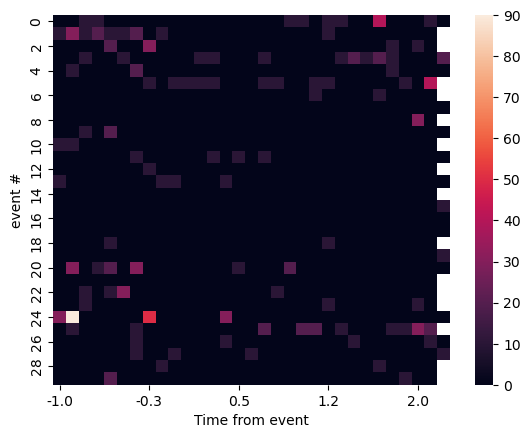

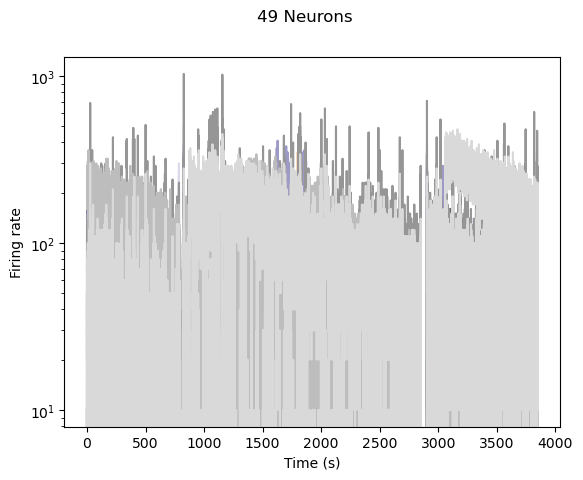

In [107]:
sess.bst = sess.neurons.get_binned_spiketrains(bin_size=0.1)
sess.binned_peraster = binned_pe_raster(sess.bst, event_times=s1_start, neuron_id=2, buffer_sec=(1,2))

bin_fig = spikes.plot_binned_raster(sess.bst, event_times=s1_start, buffer_sec=(1,2), neuron_id=2)
fr_fig = spikes.plot_firing_rate(sess.neurons, bin_size=0.1)

In [18]:
sess.phy